# Competition in the car market 

In [731]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.optimize import minimize
import statsmodels.formula.api as smf

sns.set_theme()

%load_ext autoreload
%autoreload 2

import estimation 
import logit
import data 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [732]:
# read in the dataset on car sales 
cars = pd.read_csv('cars.csv')

In [733]:
cars.sample(3)

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,pop,ngdp,rgdp,engdp,ergdp,engdpc,ergdpc,inc,qu_tot,s
5267,81,5,230,237,23,rover ital,rover,ital,7,12,...,56350000,254926995456,4.180260e+11,427476647936,7.009707e+11,7586.098633,12439.586914,20689.6935,1199210,0.039497
5517,87,5,294,294,31,volvo 340,volvo,340,6,8,...,57010000,423381008384,5.116150e+11,539673985024,6.521438e+11,9466.303711,11439.113281,24407.0458,1728907,0.022576
438,80,1,297,293,31,volvo 240,volvo,240,6,11,...,9850000,3508400029696,5.446300e+12,90813194240,1.409748e+11,9219.613281,14312.161133,26093.9906,286242,0.020909


In [734]:
# some useful labels to better understand the data
labs = pd.read_csv('labels_values.csv')
dict_varnames = pd.read_csv('labels_variables.csv').set_index('variable').to_dict()['label']
# to translate market indices to names of countries 
labs.index += 1 
dict_ma = labs.market.dropna().to_dict()

# Pandas to Numpy

Convert from pandas dataframes to numpy arrays 

In [735]:
J = 40 # car types 
T = 30 # years (1970-1999)
M = 5  # markets 

In [736]:
controls = ['home', 'hp', 'we', 'li', 'le', 'wi'] # x variables 
dummyvar = ['brd','cla'] # fixed effects for brands and car classes

x,y,x_vars = data.get_x_y(cars, control_vars=controls, dummyvarlist=dummyvar)
N,J,K = x.shape
idx_price = 0 # price is the first variable in x (along 3rd dimension)

K = 46 variables selected.


# Estimate demand

Estimate a logit model of demand. 

In [737]:
thetahat, se = estimation.estimate_m(logit, y, x, method='BFGS', cov_type='Sandwich', 
                                     options={'disp':True, 'maxiter':10_000},
                                     tol=1e-8)

         Current function value: 3.452366
         Iterations: 353
         Function evaluations: 17390
         Gradient evaluations: 370


In [738]:
# print estimates
tab = pd.DataFrame({'Est':thetahat, 'se': se}, index = x_vars)
tab

,Est,se
p,-1.359982,0.109271
home,1.381863,0.033725
hp,-0.007496,0.001750
we,0.000286,0.000195
li,-0.068490,0.016542
le,-0.006184,0.001025
wi,0.047971,0.003557
brd=2,0.486201,0.061104
brd=3,0.852718,0.073427
brd=4,0.090568,0.057484


# Selecting country-year

Now, we zoom in on the competition in one particular market (country-and-year combination). 

Selecting Germany in 1999. 

In [739]:
country = 'Germany'
year = 99
I = (cars['ma'].map(dict_ma) == country) & (cars['ye'] == year)

In [740]:
# select the rows of the dataset that corresponds to I 
market_data = cars.loc[I].reset_index()

In [741]:
# information about Germany in 1999 
population = market_data['pop'].unique()[0]
gdp = market_data['ngdp'].unique()[0]
gdp_per_capita = gdp / population
print(f'{country} has {population:,} people and {gdp:,} GDP in {year}')

Germany has 82,020,000 people and 3,849,660,137,472 GDP in 99


Create `x`: The matrix of regressors for Germany in 1999. It is $1 \times J \times K$, where 

* 1 = number of markets (there is just one) 
* $J = 40$ = number of available cars 
* $K = $ number of regressors in the logit demand model

In [742]:
# to predict market shares, we need a matrix of car characteristics for all cars available in Germany in 1999
idx = cars.loc[I].index.values
x = x.reshape(N*J,K)[idx,:].reshape(1,J,K)

# later we will need a function for changing the price in the x-matrix used by the logit functions
def set_car_price(x, p:float, j:int) -> None:
    # writes to the input!  
    x[:,j,idx_price] = p/gdp_per_capita # in the model, price is relative to gdp per capita


# Product-level competition

For the first questions, we assume that each *product* is a separate firm. We pick out two products to study since most of our work is about 2-player games (so we assume that the remaining product prices do not respond). 

In [743]:
j1 = 22 # car type 1
j2 = 34 # car type 2 

# let's print some details about the selected variables 
cols = ['type', 'brand', 's', 'qu', 'pr', 'we', 'hp', 'li1']
market_data.loc[[j1,j2], cols].rename(columns=dict_varnames)

,name of brand and model,name of brand,market share (qu / qu_tot),sales (number of new car registrations),price (in destination currency including V.A.T.),weight (in kg),horsepower (in kW),"measure 1 for fuel efficiency (liter per km, at 90 km/h)"
22,volkswagen passat,VW,0.050595,136575,37800.0,1230,74.0,6.1
34,ford focus,ford,0.041837,112933,25850.0,1070,55.0,5.2


In [744]:
# predict market shares in the baseline 
s = logit.choice_prob(thetahat, x)

# print it and compared to observed market shares 
pd.DataFrame({'Market share, data': market_data.loc[[j1,j2], 's'].values, 'Market share, model': s[0,[j1,j2]]}, 
index = market_data.loc[[j1,j2], 'type'].values)

,"Market share, data","Market share, model"
volkswagen passat,0.050595,0.028085
ford focus,0.041837,0.040611


## The profit functions

Given these two products and (strong!) assumptions on marginal costs, we can compute the profits using our demand model. 

In [745]:
p1_data = market_data.loc[j1, 'pr'] # raw sticker price of the car in the data 
p2_data = market_data.loc[j2, 'pr'] # ... for car 2 

# we assume that marginal cost is 50% of the sticker price.... 
c1 = 0.5 * p1_data
c2 = 0.5 * p2_data

def market_shares(p1, p2): 
    x2 = x.copy() # copy to avoid writing to the original data 
    set_car_price(x2, p1, j1) # set the price of car j1 to the p1 (measured in the model's units)
    set_car_price(x2, p2, j2) # ... for car j2
    ccp = logit.choice_prob(thetahat, x2)
    s1 = ccp[0,j1] 
    s2 = ccp[0,j2] 
    return s1, s2

def profit(p, s, c): 
    # profit = Q * (p-c)
    return population * s * (p - c) / 1_000_000_000 # in 100 million EUR

def profit1(p1, p2): 
    s1, s2 = market_shares(p1, p2)
    pi1 = profit(p1, s1, c1)
    return pi1

def profit2(p2, p1): # note the order of inputs!!
    s1, s2 = market_shares(p1, p2)
    pi2 = profit(p2, s2, c2)
    return pi2

In [746]:
print(f'Baseline predicted profit for car {j1} ({market_data.loc[j1,"type"]}): {profit1(p1_data, p2_data):,.1f} million EUR')
print(f'Baseline predicted profit for car {j2} ({market_data.loc[j2,"type"]}): {profit2(p2_data, p1_data):,.1f} million EUR')

Baseline predicted profit for car 22 (volkswagen passat): 43.5 million EUR
Baseline predicted profit for car 34 (ford focus): 43.1 million EUR


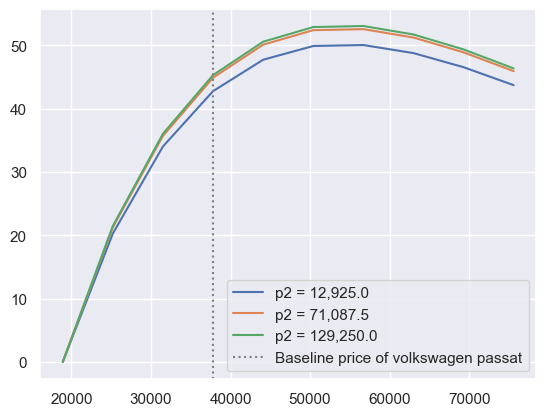

In [747]:

# printing the profit function for three values of the competitor price 
pp1 = np.linspace(0.5,2.,10) * p1_data
pp2 = np.linspace(0.5,5.,3) * p2_data
pi1 = np.empty((pp1.size,pp2.size))
for i2,p2 in enumerate(pp2): 
    for i1,p1 in enumerate(pp1): 
        pi1[i1,i2] = profit1(p1, p2)

    plt.plot(pp1, pi1[:,i2], label=f'p2 = {p2:,}')
plt.axvline(p1_data,color='gray',linestyle=':', label=f'Baseline price of {market_data.loc[j1,"type"]}')
plt.legend(); 

***... continue from here ...***

In [748]:
guess = np.array([40000])

def BR1(p2): 
    p1 = minimize(lambda p: -profit1(p, p2), guess, method='BFGS').x[0]
    return p1
def BR2(p1): 
    p2 = minimize(lambda p: -profit2(p, p1), guess, method='BFGS').x[0]
    return p2


y0 = np.array([40000, 40000])
def IBR(y0:np.ndarray, BR1, BR2, maxit=100, tol=1e-7) -> np.ndarray: 
    assert y0.size == 2 
    y1,y2 = y0 
    success = False

    for it in range(maxit): 
        # copy the old values
        y1_ = y1*1.
        y2_ = y2*1.

        # update y1 and y2 
        # FILL IN 
        y1 = BR1(y2_)
        y2 = BR2(y1_)

        if (np.abs(y1-y1_).max() < tol) and (np.abs(y2-y2_).max() < tol):
            print(f'IBR successful after {it} iterations')
            success = True
            break 

    if not success: 
        print(f'IBR failed after {it} iterations')

    return np.array([y1,y2])

ibrr = IBR(y0, BR1, BR2)
ibrr

IBR failed after 99 iterations


array([53980.14444991, 48216.76894319])

In [749]:
guess = np.array([40000])

y0 = np.array([40000, 40000])

# Define kartel profit function
def kartel_profit(p1, p2):
    return profit1(p1, p2) + profit2(p2, p1)


def kBR1(p2): 
    p1 = minimize(lambda p: -kartel_profit(p, p2), guess, method='BFGS').x[0]
    return p1
def kBR2(p1): 
    p2 = minimize(lambda p: -kartel_profit(p1, p), guess, method='BFGS').x[0]
    return p2

# Run iterative best response
kibr = IBR(y0, kBR1, kBR2)
print(f'IBR solution: {kibr}')

IBR failed after 99 iterations
IBR solution: [54889.19610241 48883.9866549 ]


# Brand-level competition

For the next questions, we consider competition across *brands* as opposed to individual products. 

At the brand-level, for example VW has 5 cars in Germany in 1999, so it sets 5 prices. To simplify matters, let us assume that VW only considers setting a single of those 5 prices, so that it scales all of its prices linearly, i.e. it chooses a single scalar, $p \ge 0$, which then scales all of its five prices: 

$$
\begin{align*}
P_{\text{polo}}  = p P_{\text{polo}}^{\text{data}}     \\
P_{\text{golf}}  = p P_{\text{golf}}^{\text{data}}     \\
P_{\text{pasat}} = p P_{\text{pasat}}^{\text{data}}   \\
P_{\text{lupo}}  = p P_{\text{lupo}}^{\text{data}}     \\
P_{\text{bora}}  = p P_{\text{bora}}^{\text{data}}     \\
\end{align*}
$$

So if it chooses $p = 1.0$, it gets the prices from the data (the baseline). 

In [750]:
# Choosing the two brands
brand1 = 'VW'
brand2 = 'opel'
I1 = market_data.brand == brand1
I2 = market_data.brand == brand2

# printing some data 
market_data.loc[I1 | I2, cols]

,type,brand,s,qu,pr,we,hp,li1
11,opel corsa,opel,0.041575,112226,17990.0,865,40.0,4.6
12,opel vectra,opel,0.034859,94096,35270.0,1215,74.0,5.8
13,opel omega,opel,0.010491,28318,50150.0,1460,106.0,7.1
14,opel astra,opel,0.085288,230224,25585.0,1035,48.0,5.0
20,volkswagen polo,VW,0.034536,93226,20800.0,880,37.0,4.9
21,volkswagen golf,VW,0.116060,313289,26900.0,1090,55.0,5.3
22,volkswagen passat,VW,0.050595,136575,37800.0,1230,74.0,6.1
38,volkswagen lupo,VW,0.022608,61026,18450.0,895,37.0,4.8
39,volkswagen bora,VW,0.015699,42378,33100.0,1185,74.0,6.0


In [751]:
s = logit.choice_prob(thetahat, x) # predicted market shares, (1, J)-array
pd.DataFrame({'Market share, data': [market_data.loc[I1].s.sum(), market_data.loc[I2].s.sum()],
              'Market share, pred': [s[0,I1].sum(), s[0,I2].sum()]
              }, index=[brand1,brand2])

,"Market share, data","Market share, pred"
VW,0.239499,0.259736
opel,0.172212,0.130757


## Profit functions

In [752]:

p_data = market_data['pr'].values.copy() # prices of all cars 

# assumes that mc is half of the price 
c = 0.5 * p_data # J-vector

def market_shares(p): 
    x2 = x.copy() # copy to avoid writing to the original data
    for j in range(J): 
        set_car_price(x2, p[j], j)
    s = logit.choice_prob(thetahat, x2)
    return s[0,:] # since x2.shape[0]==1, we can just take the first row

def price_vec(p1, p2) -> np.ndarray: 
    p = p_data.copy() # important to copy, otherwise we modify the original array
    p[I1] *= p1 # scales all the prices of brand1 by the factor p1
    p[I2] *= p2 # ... for brand2 
    return p 

def profit(p1, p2) -> np.ndarray: 
    '''returns a J-dimensional array of profits'''
    p = price_vec(p1, p2)
    s = market_shares(p)
    pi = population * s * (p - c) / 1_000_000_000 # in million
    return pi

def profit1(p1, p2) -> float: 
    '''
    Inputs: 
        p1,p2 are relative, so p1=1.0 sets all brand1 prices = baseline value,
        while p1=1.1 increases all brand1 prices by 10%
    '''
    pi = profit(p1, p2)
    pi1 = pi[I1].sum()
    return pi1

def profit2(p1, p2) -> float: 
    pi = profit(p1, p2)
    pi2 = pi[I2].sum()
    return pi2


In [753]:
print(f'Baseline profit to {brand1}: {profit(1.0, 1.0)[j1]:5.2f} million EUR')
print(f'Baseline profit to {brand2}: {profit(1.0, 1.0)[j2]:5.2f} million EUR')

Baseline profit to VW: 43.54 million EUR
Baseline profit to opel: 43.05 million EUR


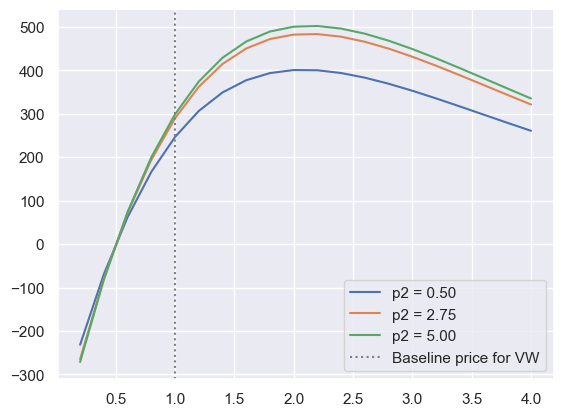

In [754]:

pp1 = np.linspace(0.2,4.,20) * 1.0
pp2 = np.linspace(0.5,5,3) * 1.0
pi1 = np.empty((pp1.size,pp2.size))
for i2,p2 in enumerate(pp2): 
    for i1,p1 in enumerate(pp1): 
        pi1[i1,i2] = profit1(p1, p2)

    plt.plot(pp1, pi1[:,i2], label=f'p2 = {p2:.2f}')
plt.axvline(1.0, color='gray', linestyle=':', label=f'Baseline price for {brand1}')
plt.legend(); 


***... continue from here...***